## Plotting

In [1]:
import collections
import json
import os
from itertools import product
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from mne_bids.path import get_entities_from_fname
from natsort import natsorted
#from rerf.rerfClassifier import rerfClassifier

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    roc_curve,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    brier_score_loss,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.utils import resample
from sklearn.calibration import calibration_curve

#import dabest
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../")
# functions related to the feature comparison experiment
from sample_code.io import read_participants_tsv
from sample_code.utils import _load_turbo, _plot_roc_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    print(f"Found mean tpr: {mean_tpr}")
    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [3]:
def combine_patient_predictions(
    ytrues, ypred_probs, subject_groups, pat_predictions=None, pat_true=None
):
    if pat_predictions is None or pat_true is None:
        pat_predictions = collections.defaultdict(list)
        pat_true = dict()

    # loop through things
    for ytrue, ypred_proba, subject in zip(ytrues, ypred_probs, subject_groups):
        pat_predictions[subject].append(float(ypred_proba))

        if subject not in pat_true:
            pat_true[subject] = ytrue[0]
        else:
            if pat_true[subject] != ytrue[0]:
                raise RuntimeError("wtf subject should all match...")
    return pat_predictions, pat_true

In [4]:
from scipy.spatial.distance import cdist

# get line between optimum and clinical op point
def create_line(x1, x2, y1, y2, n_points=200):
    slope = (y2 - y1) / (x2 - x1)

    xs = np.linspace(x1, x2, n_points)
    ys = np.linspace(y1, y2, n_points)

    return xs, ys


def find_intersect_idx(x1s, y1s, x2s, y2s):
    """Help find intersection points between two curves."""
    euc_dists = []
    points = np.vstack((x2s, y2s)).T
    for idx, (x1, y1) in enumerate(zip(x1s, y1s)):
        point = np.array([x1, y1])[np.newaxis, :]
        dists = cdist(points, point)
        euc_dists.append(min(dists))
    return np.argmin(euc_dists)

In [5]:
bids_root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/40Hz-30/")
deriv_path = bids_root / "derivatives"
excel_fpath = Path("D:/ScalpData/JHU_scalp_clinical_datasheet_raw_local.xlsx")
feature_names = ["kldiv", "entropy", "variance", "skew", "kurtosis"]
json_fpath = Path("D:/Desktop/ezscalp/scripts/epilepsy_inds_single.json")
figures_path = Path(deriv_path) / "figures"
study_path = deriv_path / "study"

In [6]:
pat_df = read_participants_tsv(bids_root)
subjects = pat_df["participant_id"]
display(pat_df.head())

,participant_id,age,sex,hand
0,sub-001,NaN,NaN,NaN
1,sub-002,NaN,NaN,NaN
2,sub-003,NaN,NaN,NaN
3,sub-004,NaN,NaN,NaN
4,sub-005,NaN,NaN,NaN


In [7]:
outcomes = []

# get a list of all the outcomes
for ind, subj in enumerate(np.unique(subjects)):
    # use excel file to set various data points
    pat_row = pat_df[pat_df["participant_id"] == subj]
    patient = pat_row["participant_id"].values[0]
    if ind % 2 == 0:
        outcomes.append('S')
    else:
        outcomes.append('F')
    
print(outcomes)

['S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S']


In [8]:
n_success = len(np.argwhere(np.array(outcomes) == "S"))
clinical_sensitivity = n_success / len(outcomes)
clinical_fpr = (len(outcomes) - n_success) / len(outcomes)

print(f"Clinical sensitivity: {clinical_sensitivity}")
print(f"Clinical False Positive Rate: {clinical_fpr}")

Clinical sensitivity: 0.5048543689320388
Clinical False Positive Rate: 0.49514563106796117


## Plotting Comparisons

In [9]:
# identifying strings for each feature representation of the data
feature_name = "sourcesink"

## Setup for run
names = {
    "Log. Reg": "blue",
    # "Lin. SVM": "firebrick",
    #"SVM": "purple",
    #     "kNN": "black",
    #"RF": "#f86000",
    #"MLP": "green",
    #"cnn": "magenta",
    #"xgb": "black",
    #"dummby": "teal",
    #"sporf": "red",
    #"mtmorf": "orange",
}

In [10]:
# dictionary data structure to hold all the CV experiment results
nested_scores_feature = dict()

for clf_name in names:
    # nested CV estimators
    nested_scores_search_pattern = f"study_cv_scores_{clf_name}_{feature_name}_*.json"
    nested_scores = None

    # get all json files that follow that search pattern
    fpaths = (
        study_path
        / "clf-train-vs-test"
    ).glob(nested_scores_search_pattern)

    fpaths = natsorted(fpaths)
    for idx_, json_fpath in enumerate(fpaths):
        idx = idx_ + 1
        with open(json_fpath, "r") as fin:
            _nested_scores = json.load(fin)

        
        # either append to the nested dictionary, or create it
        # some magic done to cast numbers in case they were saved in different formats
        if nested_scores is None:
            """
            for key, val in _nested_scores.items():
                if key in [
                    "validate_ytrue",
                    "validate_fpr",
                    "validate_tpr",
                    "validate_pat_true",
                    "validate_pat_predictions",
                ]:
                    while len(val) <= 10 and (
                        isinstance(val[0], list) or isinstance(val[0], dict)
                    ):
                        #                         print([len(x) for x in val])
                        val = val[-1]
                #                         print(len(val))
                else:
                    continue
                """
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                #                 if key == [
                #                     "validate_ytrue",
                #                 ]:
                #                     val = val[0]
                #                     for idx, y in enumerate(val):
                #                         val[idx] = y[0]
                if key in [
                    "validate_ytrue",
                    "validate_fpr",
                    "validate_tpr",
                    "validate_pat_true",
                    "validate_pat_predictions",
                ]:
                    val = val[0]
                    """
                    while len(val) <= 10 and (
                        isinstance(val[0], list) or isinstance(val[0], dict)
                    ):
                        
                        #                         print([len(x) for x in val])
                        val = val[-1]
                    """
                #                         print(len(val))
                nested_scores[key].append(np.array(val).squeeze())
    print(f"There should be 10 total CV for {clf_name}. We found {len(fpaths)}")
    nested_scores_feature[clf_name] = nested_scores

There should be 10 total CV for Log. Reg. We found 9


In [11]:
auc_feat_names = []
auc_feat_scores = []
mean_tpr_scores = []
mean_fpr_scores = []

for name, nested_scores in nested_scores_feature.items():
    print(name)
    #print(nested_scores)
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores["validate_fpr"], nested_scores["validate_tpr"]
    #[print(fpr) for fpr in fprs]
    #print(tprs)
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)
    #print(mean_tpr)
    mean_tpr_scores.append(mean_tpr)
    mean_fpr_scores.append(mean_fpr)

    auc_feat_names.append(name)
    auc_feat_scores.append(np.mean(aucs))

auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Log. Reg
Computing average ROC over 9 CV splits
Found mean tpr: [0.         0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.14814815 0.14814815 0.14814815 0.14814815
 0.14814815 0.14814815 0.14814815 0.2962963  0.2962963  0.2962963
 0.2962963  0.2962963  0.2962963  0.2962963  0.37037037 0.37037037
 0.37037037 0.37037037 0.37037037 0.37037037 0.40740741 0.40740741
 0.40740741 0.40740741 0.40740741 0.40740741 0.40740741 0.48148148
 0.48148148 0.48148148 0.48148148 0.48148148 0.48148148 0.48148148
 0.48148148 0.48148148 0.48148148 0.48148148 0.48148148 0.48148148
 0.51851852 0.51851852 0.51851852 0.51851852 0.51851852 0.51851852
 0.51851852 0.51851852 0.51851852 0.51851852 0.51851852 0.51851852
 0.51851852 0.55555556 0.55555556 0.55555556 0.55555556 0.55555556
 0.55555556 0.55555556 0.55555556 0.55555556 0.55555556 0.55555556

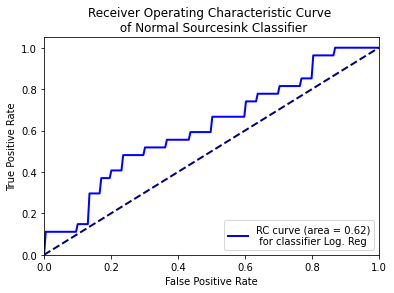

In [12]:
plt.figure()
for ind, (name, color) in enumerate(names.items()):
    lw = 2
    plt.plot(mean_fpr_scores[ind], mean_tpr_scores[ind], color=color,
             lw=lw, label=f'RC curve (area = {round(auc_feat_scores[ind],2)})\n for classifier {name}')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve \n of Normal Sourcesink Classifier')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
nested_scores.keys()

dict_keys(['validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_subject_groups', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std'])

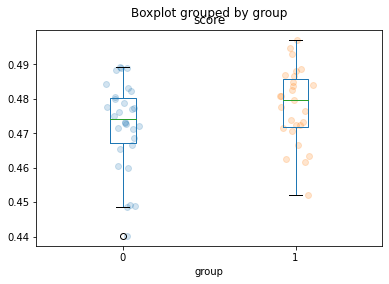

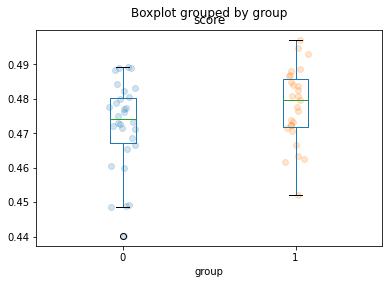

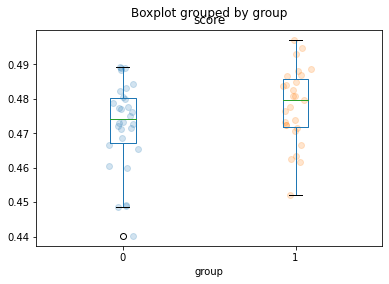

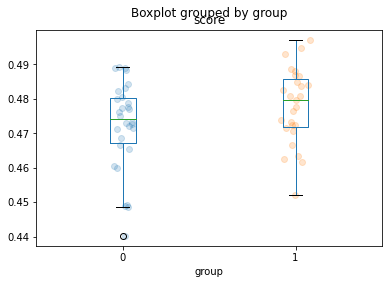

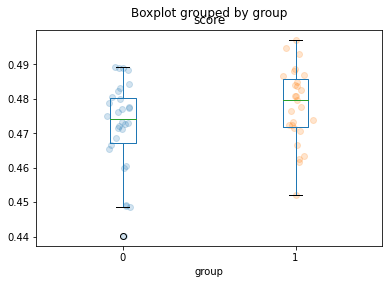

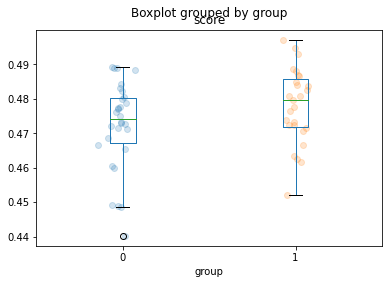

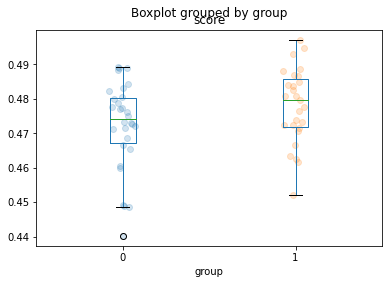

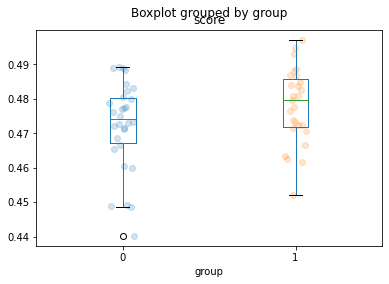

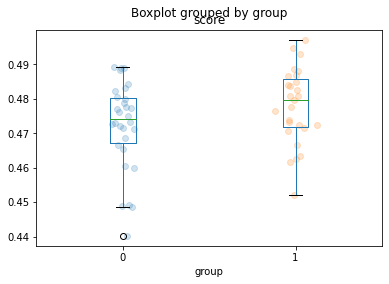

In [14]:
for ypred, pt_groups in zip(nested_scores['validate_ypred_prob'], nested_scores['validate_subject_groups']):
    ypred = np.array(ypred).reshape(-1, 1)
    pt_groups = np.array(pt_groups).reshape(-1, 1)
    score_df = pd.DataFrame()
    score_df['score'] = ypred.flatten()
    score_df['group'] = pt_groups.flatten()
    bp = score_df.boxplot(column='score', by='group', grid=False)
    for group in [0,1,2]:
        group_inds = [i for i, val in enumerate(pt_groups) if val == group]
        ypred_group = ypred[group_inds]
        x = np.random.normal(group+1, 0.04, size=len(ypred_group))
        plt.scatter(x, ypred_group, alpha=0.2)

In [15]:
# store all AUCs and Average Precision metrics
feature_aucs = dict()
feature_prs = dict()
feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# show some summary statements?
verbose = False

Computing average ROC over 9 CV splits
Found mean tpr: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


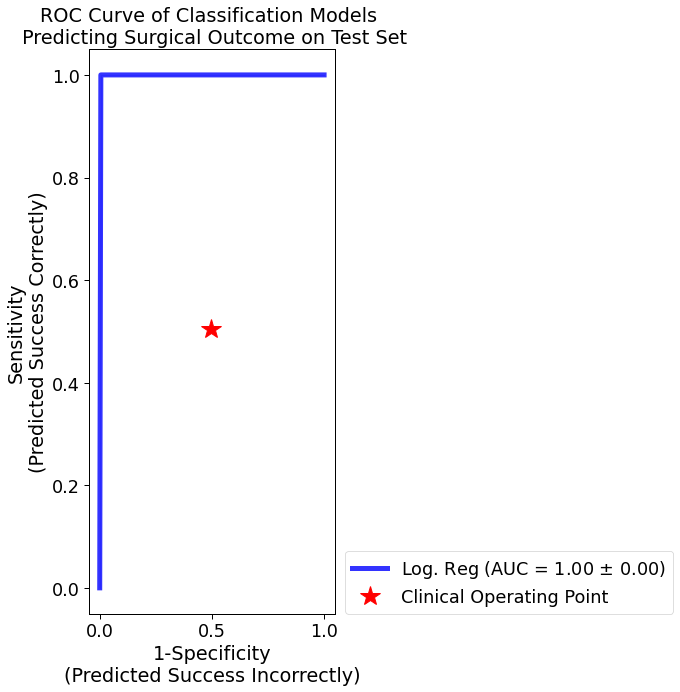

In [16]:
sns.set_context("paper", font_scale=2.0)

# figure to show ROC
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# color scheme
# colors = [
#     "blue",
#     "orange",
#     "green",
#     "magenta",
#     "black",
#     "green",
#     "red",
#     "gray",
#     "brown",
#     "teal",
#     "purple",
# ]

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    # extract the feature name for plotting
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]

    # get the test set performances for this feature
    nested_scores = nested_scores_feature[feature_name]

    # extract the predicted probability of success, the true outcomes
    # for each 10 fold CV
    pat_predict_proba = nested_scores["validate_pat_predictions"]
    pat_true = nested_scores["validate_pat_true"]

    # initialize lists to store certain metrics we want to keep track of
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []

    # for visual sake only show the top 3 performing based on average AUC
    #     if idx > 3:
    #         idx = 4
    feature_name = (
        feature_name.upper()
        .replace("CNN", "ConvNet")
        .replace("LOG. REG", "Log. Reg")
        .replace("CONVNET", "ConvNet")
        .replace("MTMORF", "MORF")
    )
    color = names[feature_name]

    # loop through each CV fold (10 in total)
    for jdx in range(len(pat_true)):
        # in case data was stored in different formats, just pull them out
        # byproduct of saving w/ different encoding...
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()

        # keep each patient's probability of success prediction, true outcome and list
        # of subjects in the test dataset
        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)

        # set the patient predictions based on the success probability prediction
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)

        # compute a balanced accuracy score of the predicted outcomes vs true outcomes
        acc = balanced_accuracy_score(pat_y, pat_predictions)

        # compute the number of failures/success per CV fold and the ratio of each
        n_true_succ = len(
            [y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1]
        )
        n_true_fail = len(
            [y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0]
        )
        num_fail = len(
            [
                y_
                for y_, ytrue_ in zip(pat_predictions, pat_y)
                if y_ == ytrue_
                if ytrue_ == 0
            ]
        )
        num_success = len(
            [
                y_
                for y_, ytrue_ in zip(pat_predictions, pat_y)
                if y_ == ytrue_
                if ytrue_ == 1
            ]
        )
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)

        # create the roc curve on this fold
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)

        # store the subjects, predicted probabilities and feature names
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    ytrues, ypreds = (
        nested_scores["validate_ytrue"],
        nested_scores["validate_ypred_prob"],
    )
    if verbose:
        ### Now compute statistics for summary, such as accuracies, f1scores,
        accs = []
        f1s = []
        for ytrue, ypred in zip(ytrues, ypreds):
            ytrue = np.array(ytrue).squeeze()
            ypred = np.array(ypred).squeeze()
            ypred = np.array(ypred) > 0.5
            acc = balanced_accuracy_score(ytrue, ypred)
            f1score = f1_score(ytrue, ypred)
            accs.append(acc)
            f1s.append(f1score)

        print(f"\n\n{feature_name}")
        print(f"Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}")
        print(f"F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}")
        print(f"Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}")
        print("Improvement in FPR: ", np.round(youden_point[0] - clinical_fpr, 2))
        print(
            "Improvement in TPR: ", np.round(youden_point[1] - clinical_sensitivity, 2)
        )
        print(
            "Total distance: ",
            np.linalg.norm(
                (youden_point[0] - clinical_fpr, youden_point[1] - clinical_sensitivity)
            ),
        )
        print(f"Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}")
        print(f"Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}")
        print(f"Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}")
        print(
            f"Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}"
        )
        print(
            f"Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}"
        )

    # compute the average ROC curve from the above loop over nested CV
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # compute the avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    feature_aucs[feature_name] = aucs

    # actually plot the ROC curve
    ax = _plot_roc_curve(
        mean_tpr,
        mean_fpr,
        mean_auc=mean_auc,
        std_auc=std_auc,
        label=feature_name,
        ax=ax,
        color=color,
        plot_chance=False,
    )

    # plot youden point on the curve
    xs, ys = create_line(clinical_fpr, 0, clinical_sensitivity, 1)
    youden_idx = find_intersect_idx(mean_fpr, mean_tpr, xs, ys)
    youden_point = (mean_fpr[youden_idx], mean_tpr[youden_idx])
#     ax.plot(
#         youden_point[0],
#         youden_point[1],
#         marker="*",
#         color=color,
#         markersize=20,
#         linestyle="None",
#     )

######## format the ROC curve figure ########
ax.set(
    ylabel="Sensitivity\n(Predicted Success Correctly)",
    xlabel="1-Specificity\n(Predicted Success Incorrectly)",
    title="ROC Curve of Classification Models \n Predicting Surgical Outcome on Test Set",
    #     xlim=[0, 0.05],
    #     ylim=[0.4, 1],
)
# plot clinical point
ax.plot(
    clinical_fpr,
    clinical_sensitivity,
    marker="*",
    color="red",
    markersize=20,
    linestyle="None",
    label="Clinical Operating Point",
)

fig.tight_layout()
ax.legend(
    #     ncol=2,
    loc=(1.04, 0)
)

# save figure to disc or not?
fig.savefig(
    figures_path / "sourcesink" / f"sourcesink_vs_classifiers_quantilefeatures.pdf", bbox_inches="tight"
)